In [38]:
import pysam
import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from genepeeks.common import utilities as util
import numpy as np

In [3]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200)

Finished loading ensembl within the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.26 sec


In [44]:
bam_files_folder = '../../library_files/inputs/bam_files'

insert_lengths_d = {}
for file_path in glob.glob(os.path.join(bam_files_folder, '*.bam')):
    subject = os.path.splitext(os.path.basename(file_path))[0]
    bamfile = pysam.AlignmentFile(file_path, "rb")
    for read in bamfile.fetch('X', start=31137345, end=33229636):
        if not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped:
            in_exon = False
            all_positions = [read.reference_start, read.reference_end, read.next_reference_start]
            for position in all_positions:
                if util.in_interval(read.reference_start, DMD_exons_merged)[0]:
                    in_exon = True
                    break
            else:
                continue
                        
            if read.is_reverse == read.mate_is_reverse:
                orientation = 'Tandem'
                # orientation = 'Tandem-{}'.format('R' if read.is_reverse else 'F')
            elif read.is_reverse:
                orientation = 'RF'
            else:
                orientation = 'FR'
                if read.template_length < 0:
                    print subject, read.template_length, read.is_reverse, read.mate_is_reverse, read.reference_start, read.next_reference_start

            util.add_to_dict(insert_lengths_d, orientation, read.template_length, keep_values=True, nested_key=subject)

FR


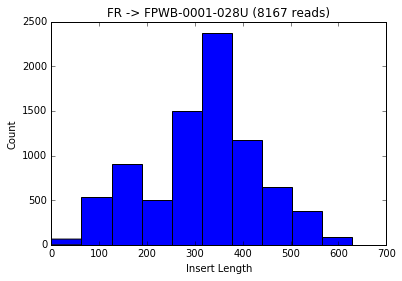

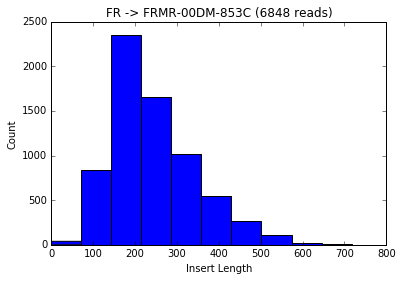

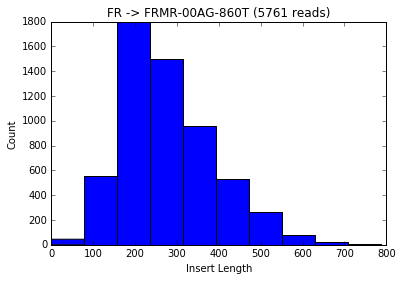

Tandem


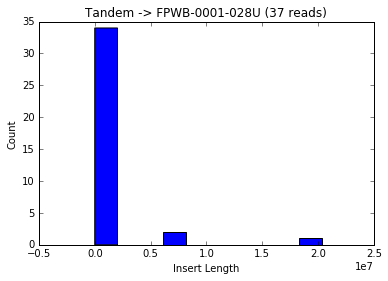

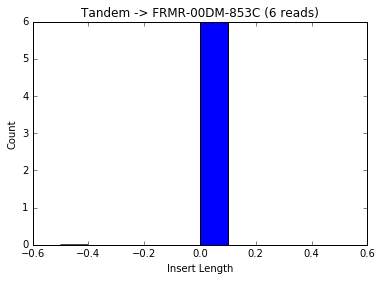

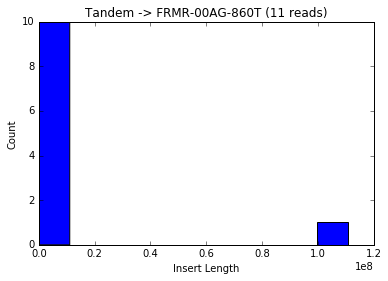

RF


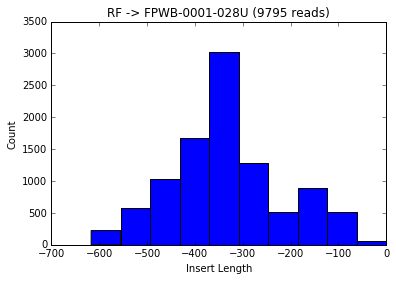

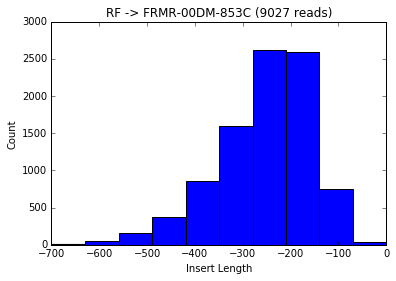

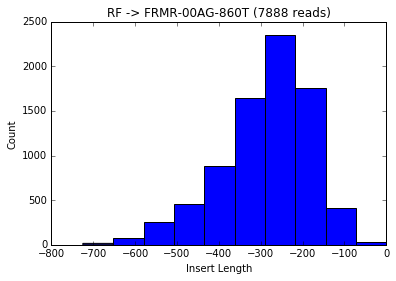

In [45]:
for orientation, subject_insert_lengths in insert_lengths_d.items():
    print orientation
    for subject, insert_lengths in subject_insert_lengths.items():
        plt.hist(insert_lengths)
        plt.title("{} -> {} ({} reads)".format(orientation, subject, len(insert_lengths)))
        plt.xlabel("Insert Length")
        plt.ylabel("Count")
        plt.show()